The Avila data set has been extracted from 800 images of the the "Avila Bible", a giant Latin copy of the whole Bible produced during the XII century between Italy and Spain.  
The palaeographic analysis of the  manuscript has  individuated the presence of 12 copyists. The pages written by each copyist are not equally numerous. 
Each pattern contains 10 features and corresponds to a group of 4 consecutive rows.

The prediction task consists in associating each pattern to one of the 12 copyists (labeled as: A, B, C, D, E, F, G, H, I, W, X, Y).
The data have has been normalized, by using the Z-normalization method, and divided in two data sets: a training set containing 10430 samples, and a test set  containing the 10437 samples.

Class distribution (training set)
A: 4286
B: 5  
C: 103 
D: 352 
E: 1095 
F: 1961 
G: 446 
H: 519
I: 831
W: 44
X: 522 
Y: 266

ATTRIBUTE DESCRIPTION

ID      Name    
F1       intercolumnar distance 
F2       upper margin 
F3       lower margin 
F4       exploitation 
F5       row number 
F6       modular ratio 
F7       interlinear spacing 
F8       weight 
F9       peak number 
F10     modular ratio/ interlinear spacing
Class: A, B, C, D, E, F, G, H, I, W, X, Y


In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import joblib

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, RandomizedSearchCV

import pickle

# Data vizualisation

In [161]:
database = pd.read_csv('avila-tr.txt', sep=",")

In [162]:
database_test = pd.read_csv('avila-ts.txt', header = None, sep=",")

In [163]:
database_test.columns = ["intercolumnar distance", "upper margin", "lower margin", "exploitation", "row number", "modular ratio",
                        "interlinear spacing", "weight", "peak number", "modular ratio/ interlinear spacing", "class"]

In [164]:
database.columns, database_test.columns

(Index(['intercolumnar distance', 'upper margin', 'lower margin',
        'exploitation', 'row number', 'modular ratio', 'interlinear spacing',
        'weight', 'peak number', 'modular ratio/ interlinear spacing',
        ' class'],
       dtype='object'),
 Index(['intercolumnar distance', 'upper margin', 'lower margin',
        'exploitation', 'row number', 'modular ratio', 'interlinear spacing',
        'weight', 'peak number', 'modular ratio/ interlinear spacing', 'class'],
       dtype='object'))

In [165]:
database.dtypes, database_test.dtypes

(intercolumnar distance                float64
 upper margin                          float64
 lower margin                          float64
 exploitation                          float64
 row number                            float64
 modular ratio                         float64
 interlinear spacing                   float64
 weight                                float64
 peak number                           float64
 modular ratio/ interlinear spacing    float64
  class                                 object
 dtype: object,
 intercolumnar distance                float64
 upper margin                          float64
 lower margin                          float64
 exploitation                          float64
 row number                            float64
 modular ratio                         float64
 interlinear spacing                   float64
 weight                                float64
 peak number                           float64
 modular ratio/ interlinear spacing    float

#### On constate que les variables sont premièrement de même type entre train et test et surtout que l'ensemble des variables sont des float à l'exception d'une : 'class' notre variable de prédiction. On peut donc annoncer dès lors que notre problème sera celui d'une classification.

In [166]:
database.describe()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing
count,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000
mean,0.000852,0.033611,-0.000525,-0.002387,0.006370,0.013973,0.005605,0.010323,0.012914,0.000818
std,0.991431,3.920868,1.120202,1.008527,0.992053,1.126245,1.313754,1.003507,1.087665,1.007094
min,-3.498799,-2.426761,-3.210528,-5.440122,-4.922215,-7.450257,-11.935457,-4.247781,-5.486218,-6.719324
25%,-0.128929,-0.259834,0.064919,-0.528002,0.172340,-0.598658,-0.044076,-0.541992,-0.372457,-0.516097
50%,0.043885,-0.055704,0.217845,0.095763,0.261718,-0.058835,0.220177,0.111803,0.064084,-0.034513
75%,0.204355,0.203385,0.352988,0.658210,0.261718,0.564038,0.446679,0.654944,0.500624,0.530855
max,11.819916,386.000000,50.000000,3.987152,1.066121,53.000000,83.000000,13.173081,44.000000,4.671232


#### On constate que les varaibles varient fortement statistiquement : moyenne, variances et quartiles ; une normalisation semble nécessaire

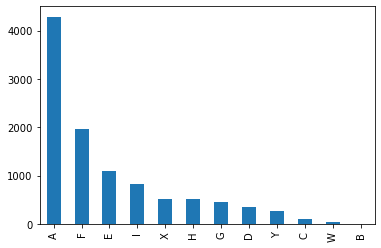

In [167]:
database[' class'].value_counts().plot(kind='bar');

#### On observe que la répartition des données est inégale ! La classe A est très fortement représentée à l'inverse de la classe W par exemple ! La distribution ne sera pas comparable à une distribution équiprobable

<Figure size 432x288 with 0 Axes>

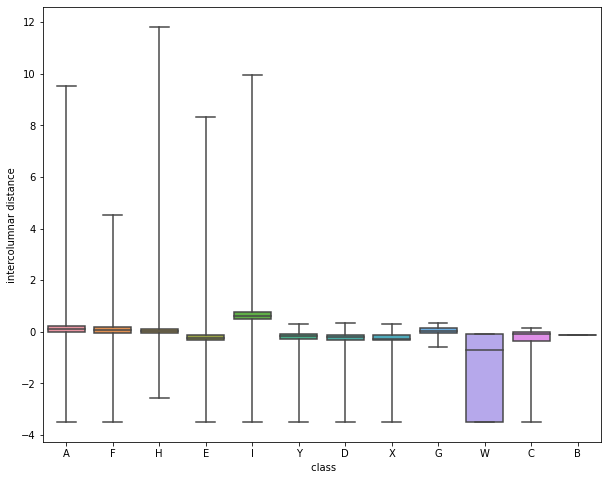

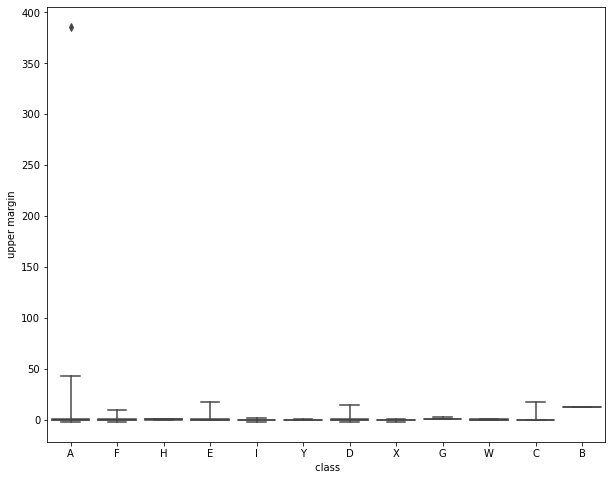

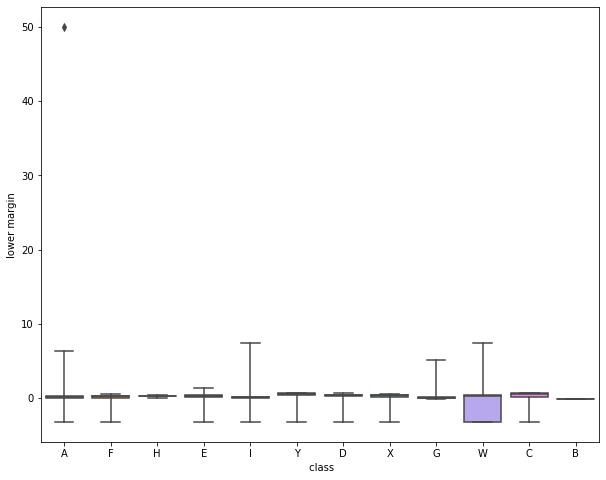

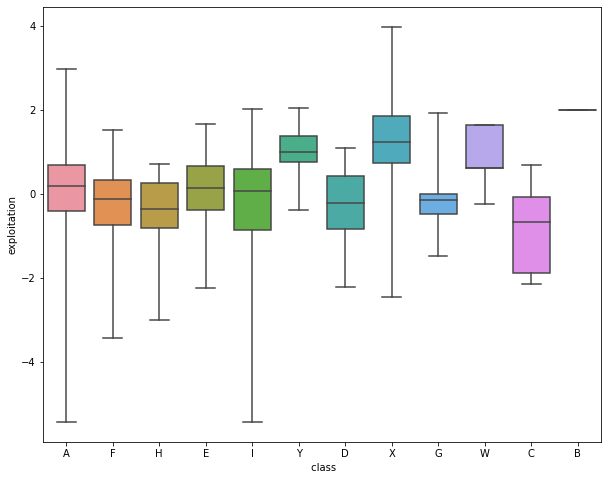

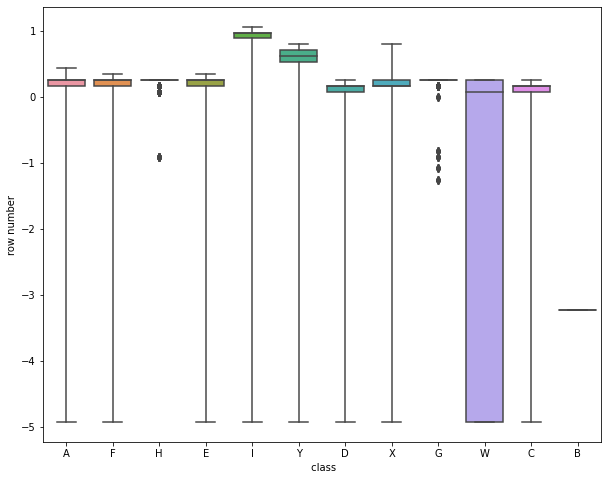

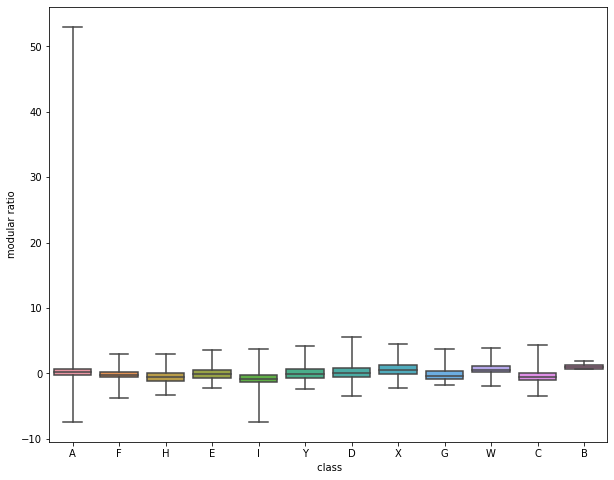

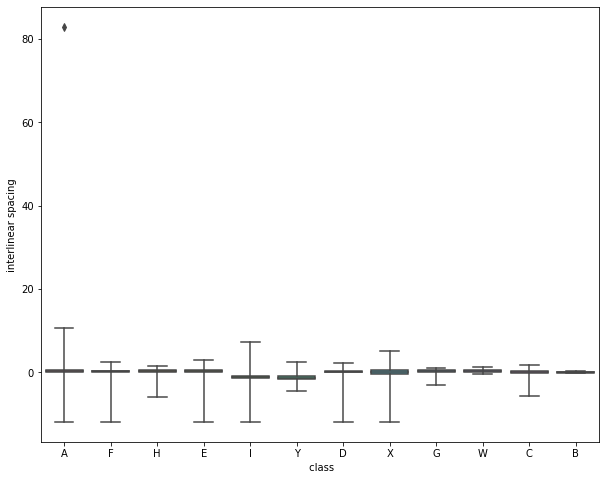

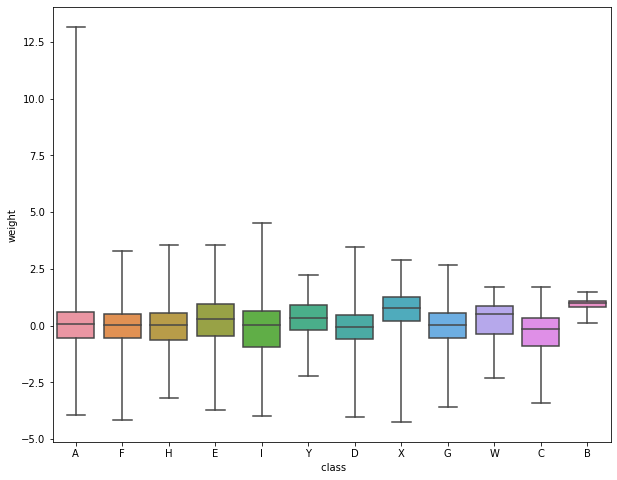

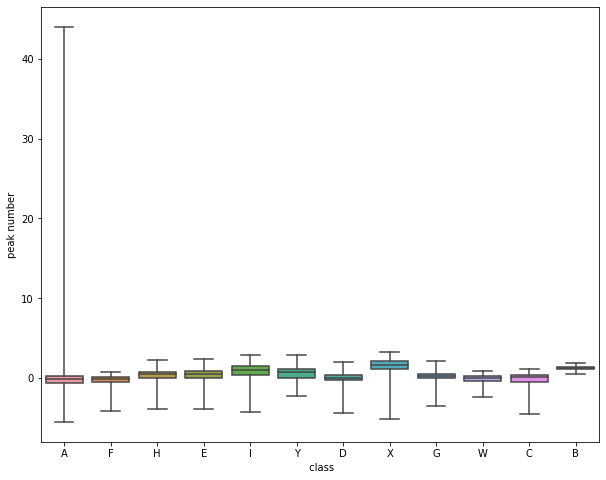

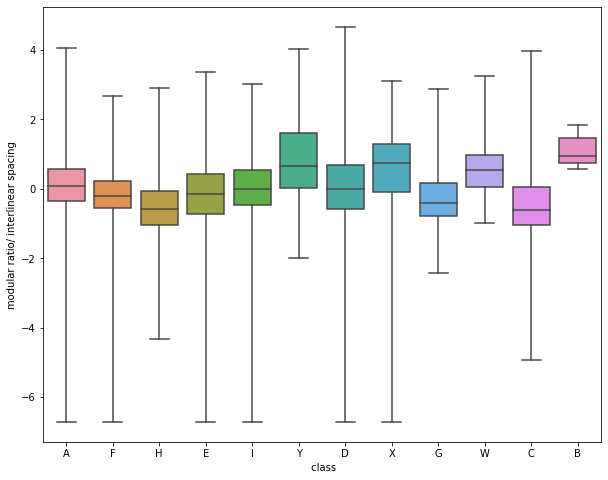

In [168]:
list_var = database.columns[:-1]
fig = plt.figure()

for i in list_var:
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.boxplot(x=' class',y=i,data=database,whis=150)
plt.show()

#### Nous pouvons voir dans ces boxplots que certaines variables possèdent de très grosses disparités en fonction de la classe-cible : par exemple, on remarque dans les boxplots, que pour les variables 'intercolumnar_distance', 'lower_margin' et 'row number', la classe-cible "W" a une valeur bien plus faible que toutes les autres classes alors que pour les variables 'variable exploitation' et 'peak_number', c'est bien la classe-cible "C" qui a la valeur la plus faible de toutes les classes ! 

#### Cependant, nous remarquons également que d'autres variables possèdent des valeurs très équilibrées entre les classes telles que 'diff', 'modular_ration' et 'upper_margin'. 

#### Ces disparités vont faciliter le travail de classification pour qu'elles mettent en évidence les relations entre certaines variables et certaines classes

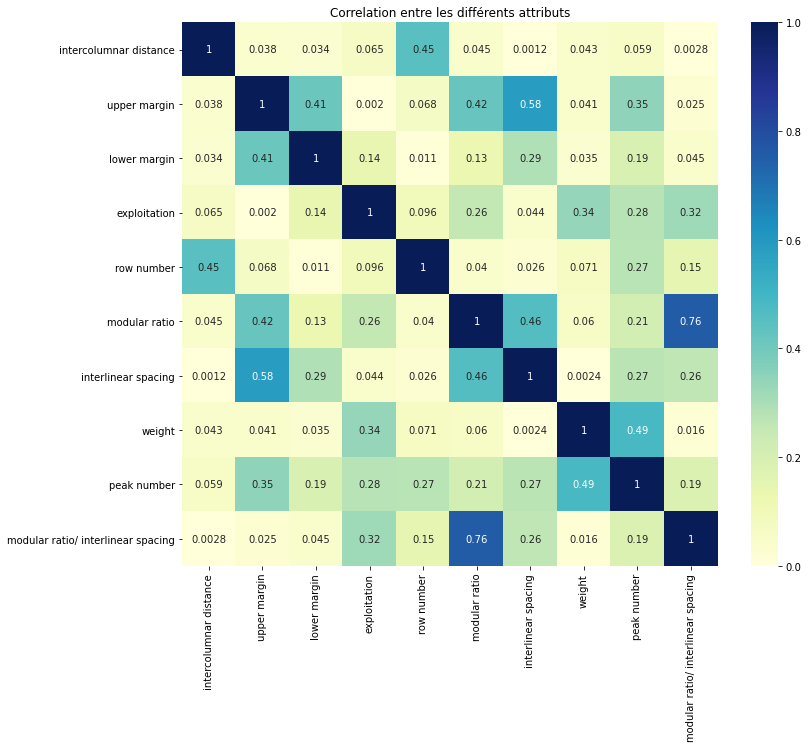

In [169]:
plt.figure(figsize=(12, 10))
sns.heatmap(database.corr().abs(), vmax=1, vmin=0, annot=True,  cmap='YlGnBu')
plt.title('Correlation entre les différents attributs')
plt.show()

#### On observe grâce à cette heatmap que les variables sont relativement peu corrélées entre elles (à l'exception de quelques variables telles que : modular ration & interlinear spacing). Cela rend difficile d'évincer des varaiables peu porteuses d'information puisque les variables semblent indépendantes entre elles.

#### Notons que la dernière variable,  "modular ration/interlinear spacing", est une variable composée entre deux autres variables du dataset et peut donc être retirée du dataset puisque porteuse de peu d'informations en tant que telle

C:\Users\quent\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\quent\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


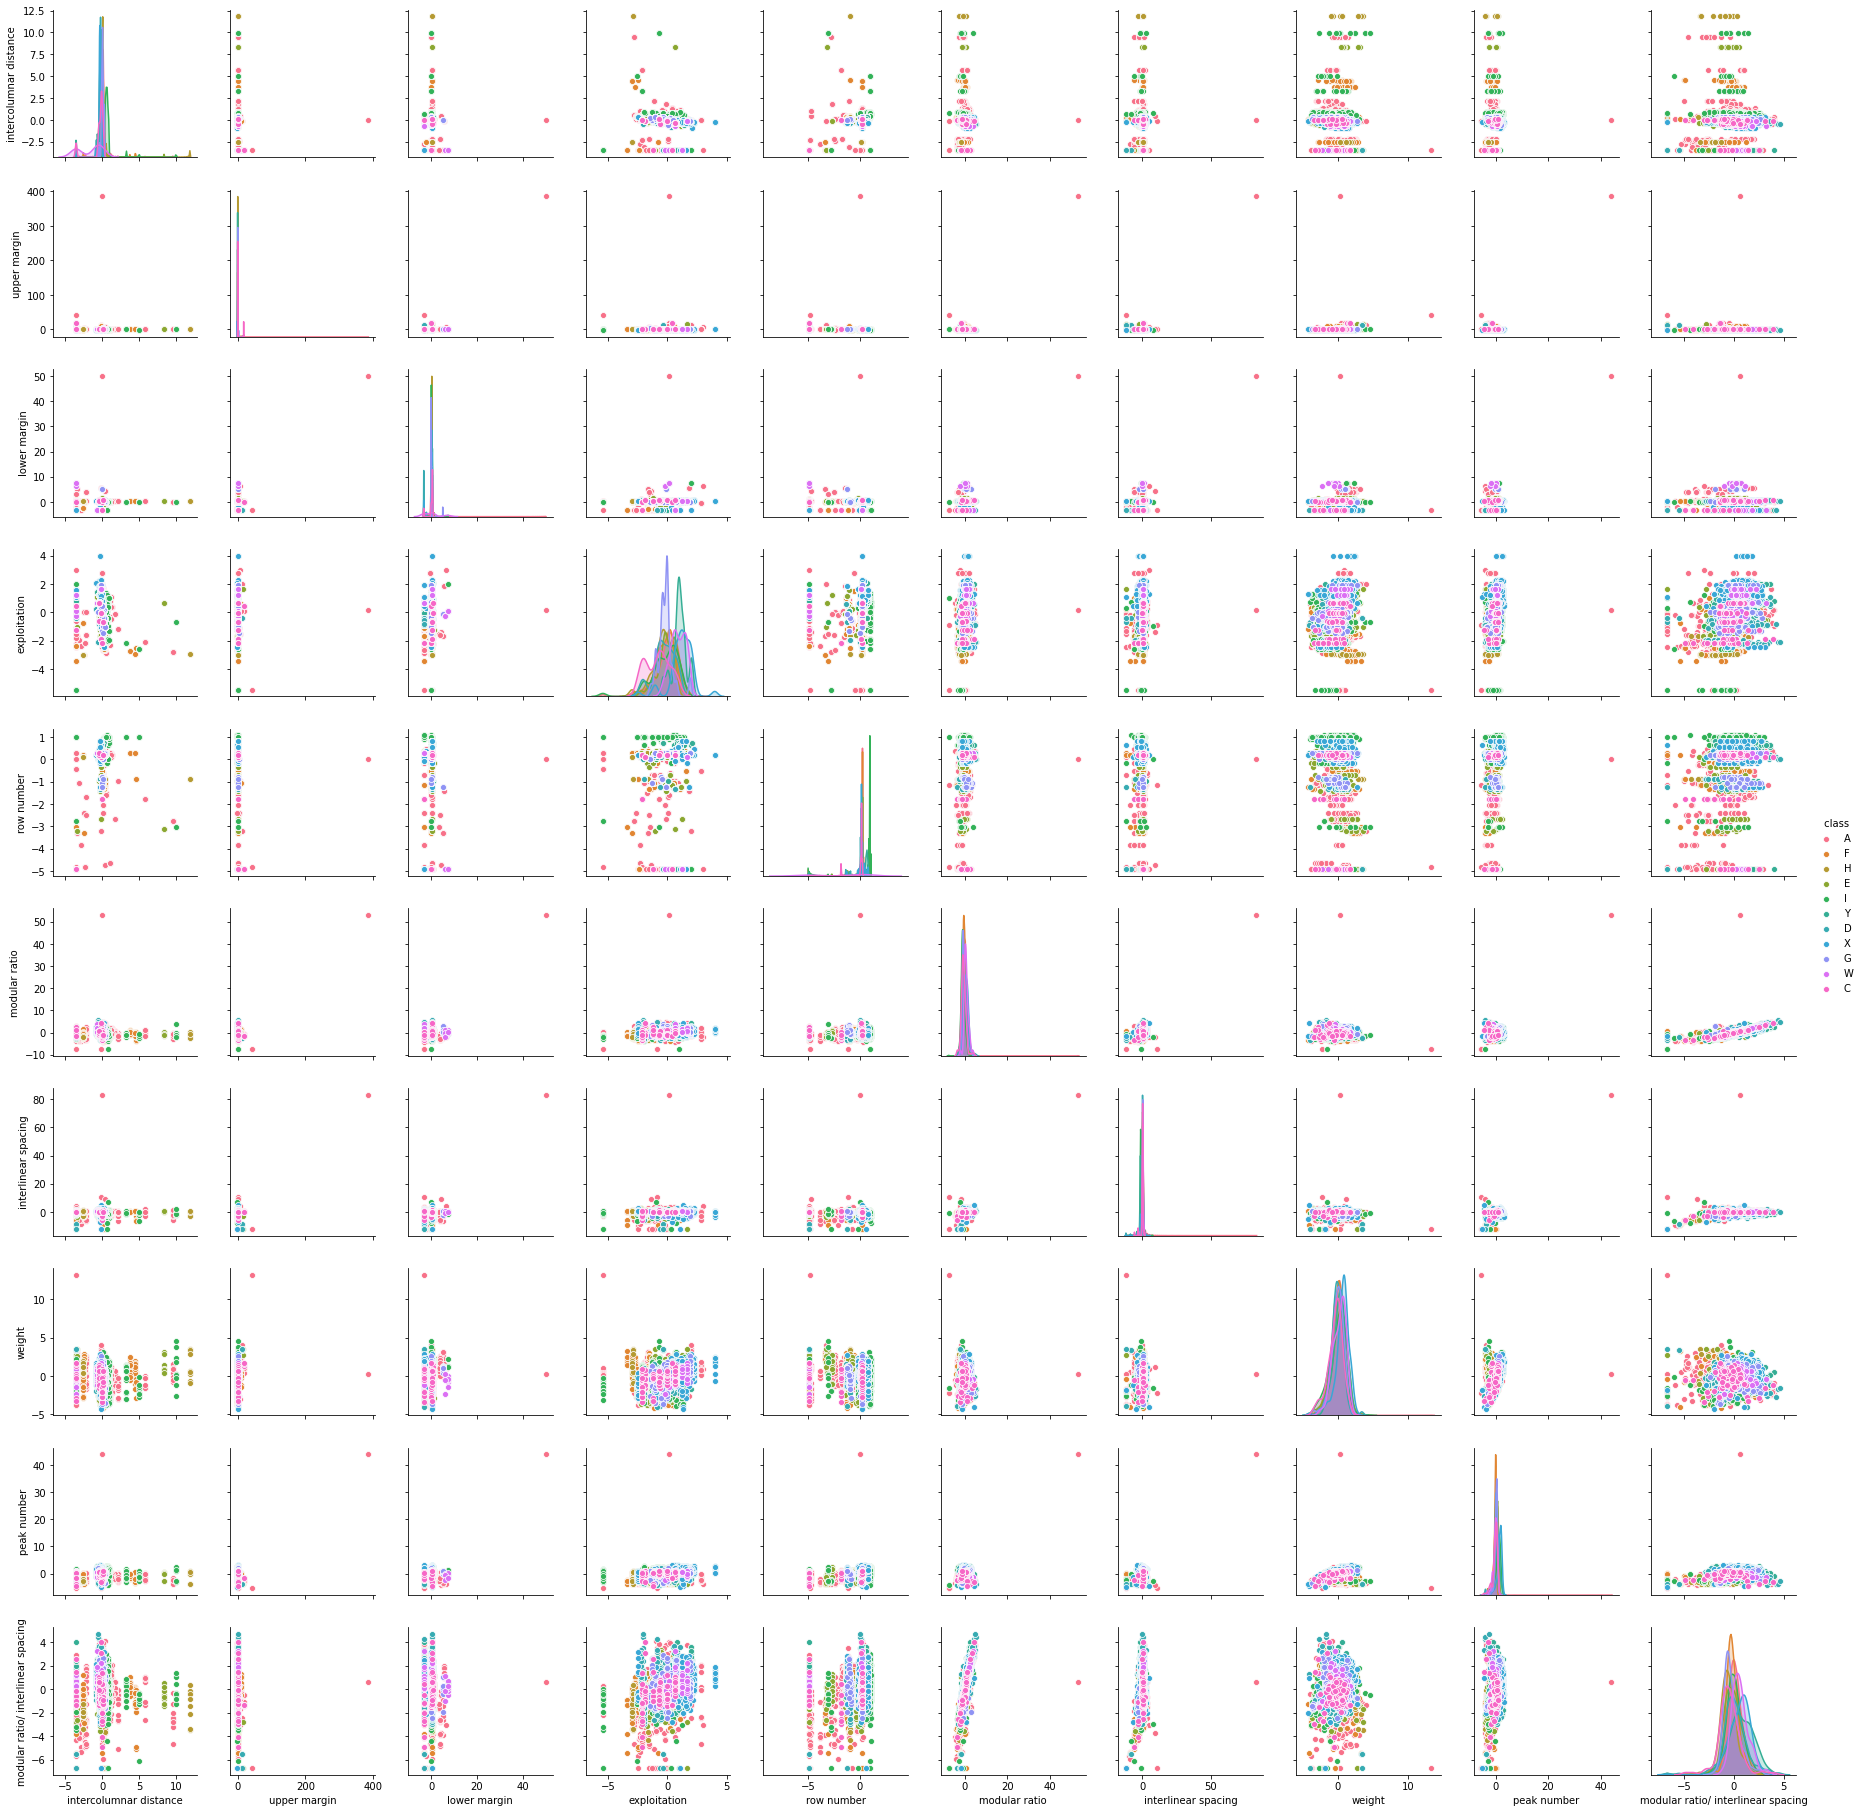

In [170]:
sns.pairplot(database[database[' class'] != 'B'], hue=' class')

#### Cette matrice met en évidence les relations des variable du dataset entre elles ; cette visualisation peut notamment permettre de déceler de potentielles relations entre des variables telles que des relations logarithmiques, linéaires, polynomiales ou exponentielles. 

#### Ce graphe est cependant peu concluant ; on ne remarque pas de relations évidentes entre les variables si ce n'est une relation linéaire entre "modular ratio/interlinear spacing" & "modular ratio" et  "modular ratio/interlinear spacing" & "interlinear spacing" : cela conforte la possible éviction de cette variables composée de notre modèle prédictif

# Preprocessing

In [171]:
database = database.rename(columns={"intercolumnar distance": "F1", "upper margin": "F2", "lower margin": "F3", "exploitation": "F4",
                        "row number": "F5", "modular ratio": "F6", "interlinear spacing": "F7", "weight": "F8", 
                        "peak number": "F9", "modular ratio/ interlinear spacing": "F10", " class": "class"})
database_test = database_test.rename(columns={"intercolumnar distance": "F1", "upper margin": "F2", "lower margin": "F3", "exploitation": "F4",
                        "row number": "F5", "modular ratio": "F6", "interlinear spacing": "F7", "weight": "F8", 
                        "peak number": "F9", "modular ratio/ interlinear spacing": "F10"})

In [172]:
database.columns

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'class'], dtype='object')

In [173]:
database = database.drop("F10", axis = 1)

#### On procède au drop de la colonne 'F10' comme argumentée précedemment

In [174]:
target = 'class'

In [175]:
y = database[target]
x = database.drop(target, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

#### On split le dataset en détachant la variable de prédiction afin de bien différencier X et Y

#### Test valeurs NA

In [176]:
database.isnull().values.any()

False

#### Il n'y a donc aucune valeur NA : il n'y a pas de nettoyage à faire à ce niveau

#### Normalisation des valeurs

In [177]:
scaler = preprocessing.StandardScaler().fit(x_train)

In [178]:
scaler.mean_, scaler.scale_

(array([ 8.15290029e-05,  3.92337574e-02, -4.42409036e-04, -2.35723610e-03,
         6.92026546e-03,  1.96220730e-02,  8.25948094e-03,  2.88388854e-03,
         1.55342587e-02]),
 array([0.99894214, 4.33565779, 1.14077117, 1.01447513, 0.99377668,
        1.15527424, 1.35787385, 0.99416887, 1.10969688]))

In [179]:
x_train = scaler.transform(x_train)

In [180]:
x_train.mean(axis = 0), x_train.std(axis = 0)

(array([-2.46952772e-17,  2.98046450e-18, -4.57714190e-18,  1.91601289e-18,
        -6.38670963e-17,  4.47069674e-18, -1.70312257e-17, -8.08983220e-18,
        -3.83202578e-18]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))

#### On a bien normalisé nos valeurs afin de nous assurer que les différences d'échelle entre les variables n'influent pas sur notre résultat

# Train modèles

In [181]:
def test_model_naif(model, X, y):

    accuracy = cross_val_score(model, X, y, scoring='accuracy', verbose=1).mean()
    return accuracy

In [182]:
def validation_curve_plot(hyperparametre_range, hyperparametre_train_score_mean, hyperparametre_train_score_std, 
                     hyperparametre_test_score_mean,hyperparametre_test_score_std, hyperparametre_label, methode_title, figsize=(12, 6)):

    plt.title(methode_title)
    plt.xlabel(hyperparametre_label)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(hyperparametre_range, hyperparametre_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(hyperparametre_range, hyperparametre_train_score_mean - hyperparametre_train_score_std,
                 hyperparametre_train_score_mean + hyperparametre_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.semilogx(hyperparametre_range, hyperparametre_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(hyperparametre_range, hyperparametre_test_score_mean - hyperparametre_test_score_std,
                 hyperparametre_test_score_mean + hyperparametre_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

### On créé un dictionnaire qui sera en charge de récupérer tous nos modèles entrainés !

In [183]:
liste_modeles_train = {}

#### Logistic regression

##### Test modèle sans hyper-paramètres

In [184]:
from sklearn.linear_model import LogisticRegression

In [185]:
lr_model = LogisticRegression()

In [186]:
accuracy_lr_model = test_model(lr_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

In [187]:
accuracy_lr_model

0.5522518833345547

##### Test sur les hyper-paramètres : "C", "penalty", "solver", "max_iter" 

In [188]:
C_range = np.logspace(-3, 2, 6)
solver_range = ['newton-cg', 'sag', 'saga', 'lbfgs']
max_iter_range = np.arange(1, 1000, 100)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "C" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [189]:
lr_C_train_score, lr_C_test_score = validation_curve(lr_model, x_train, y_train,
                       'C', C_range)                    

lr_C_train_score_mean = np.mean(lr_C_train_score, axis=1)
lr_C_train_score_std = np.std(lr_C_train_score, axis=1)

lr_C_test_score_mean = np.mean(lr_C_test_score, axis=1)
lr_C_test_score_std = np.std(lr_C_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=C, param_range=[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITER

C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

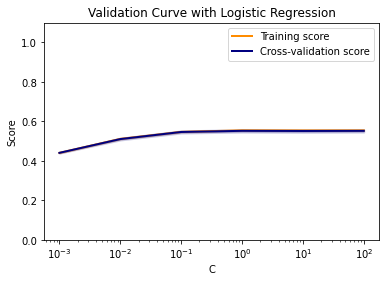

In [190]:
validation_curve_plot(C_range, lr_C_train_score_mean, lr_C_train_score_std, lr_C_test_score_mean, lr_C_test_score_std, "C", "Validation Curve with Logistic Regression")

###### On affine l'intervalle tel que:

In [191]:
C_range = np.logspace(1, 2, 6)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "solver" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [192]:
lr_max_iter_train_score, lr_max_iter_test_score = validation_curve(lr_model, x_train, y_train,
                       'max_iter', max_iter_range)

lr_max_iter_train_score_mean = np.mean(lr_max_iter_train_score, axis=1)
lr_max_iter_train_score_std = np.std(lr_max_iter_train_score, axis=1)

lr_max_iter_test_score_mean = np.mean(lr_max_iter_test_score, axis=1)
lr_max_iter_test_score_std = np.std(lr_max_iter_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=max_iter, param_range=[  1 101 201 301 401 501 601 701 801 901] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of

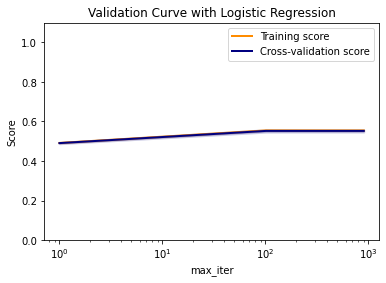

In [193]:
validation_curve_plot(max_iter_range, lr_max_iter_train_score_mean, lr_max_iter_train_score_std, lr_max_iter_test_score_mean, lr_max_iter_test_score_std, "max_iter", "Validation Curve with Logistic Regression")

###### On affine l'intervalle tel que:

In [194]:
max_iter_range = np.arange(100, 1000, 10)

##### On cherche maintenant les hyperparamètres idéaux

In [195]:
param_distributions = {'C': C_range,                       
                       'solver' : solver_range,
                       'max_iter': max_iter_range}

search = RandomizedSearchCV(estimator=LogisticRegression(random_state=0),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

RandomizedSearchCV(estimator=LogisticRegression(random_state=0), n_iter=5,
                   param_distributions={'C': array([ 10.        ,  15.84893192,  25.11886432,  39.81071706,
        63.09573445, 100.        ]),
                                        'max_iter': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]),
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=0)

In [196]:
search.best_params_, search.score(x_train, y_train)

({'solver': 'sag', 'max_iter': 880, 'C': 25.118864315095795},
 0.5522531160115053)

In [197]:
if (search.score(x_train, y_train) > accuracy_lr_model):
    lr_model = search

In [198]:
liste_modeles_train["Linear_Regression"] = lr_model

#### KNN

##### Test modèle sans hyper-paramètres

In [199]:
from sklearn.neighbors import KNeighborsClassifier

In [200]:
knn_model = KNeighborsClassifier().fit(x_train, y_train)

In [201]:
accuracy_knn_model = test_model(knn_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [202]:
accuracy_knn_model

0.7052962543087159

##### Test sur les hyper-paramètres : "n_neighbors", "weights", "algorithm", "leaf_size", "p"

In [203]:
n_neighbors_range = np.arange(1 , 100, 5)
weights_range = ['uniform', 'distance']
algorithm_range = ['ball_tree', 'kid_tree', 'brute']
leaf_size_range = np.logspace(0, 2, 6)
p_range = np.arange(1, 10, 1)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "n_neighbors" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [204]:
knn_n_neighbors_train_score, knn_n_neighbors_test_score = validation_curve(knn_model, x_train, y_train,
                       'n_neighbors', n_neighbors_range,                       
                       verbose=1)

knn_n_neighbors_train_score_mean = np.mean(knn_n_neighbors_train_score, axis=1)
knn_n_neighbors_train_score_std = np.std(knn_n_neighbors_train_score, axis=1)

knn_n_neighbors_test_score_mean = np.mean(knn_n_neighbors_test_score, axis=1)
knn_n_neighbors_test_score_std = np.std(knn_n_neighbors_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


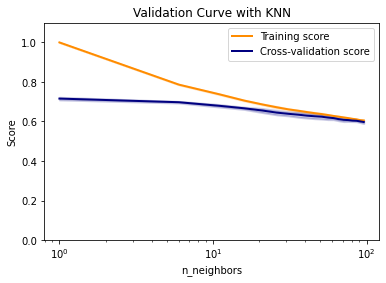

In [205]:
validation_curve_plot(n_neighbors_range, knn_n_neighbors_train_score_mean, knn_n_neighbors_train_score_std, knn_n_neighbors_test_score_mean, knn_n_neighbors_test_score_std, "n_neighbors", "Validation Curve with KNN")

###### On affine l'intervalle tel que:

In [206]:
n_neighbors_range = np.arange(5, 75, 5)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "leaf_size" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [207]:
knn_leaf_size_train_score, knn_leaf_size_test_score = validation_curve(knn_model, x_train, y_train,
                       'leaf_size', leaf_size_range,                       
                       verbose=1)

knn_leaf_size_train_score_mean = np.mean(knn_leaf_size_train_score, axis=1)
knn_leaf_size_train_score_std = np.std(knn_leaf_size_train_score, axis=1)

knn_leaf_size_test_score_mean = np.mean(knn_leaf_size_test_score, axis=1)
knn_leaf_size_test_score_std = np.std(knn_leaf_size_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=leaf_size, param_range=[  1.           2.51188643   6.30957344  15.84893192  39.81071706
 100.        ] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.0s finished


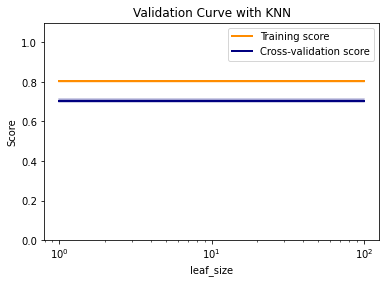

In [208]:
validation_curve_plot(leaf_size_range, knn_leaf_size_train_score_mean, knn_leaf_size_train_score_std, knn_leaf_size_test_score_mean, knn_leaf_size_test_score_std, "leaf_size", "Validation Curve with KNN")

###### On arrive à la conclusion que leaf_size n'est pas un hyperparamètre intéréssant à manipuler !

###### On commence par affecter un large espace de recherche pour la valeur optimale de "p" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [209]:
knn_p_train_score, knn_p_test_score = validation_curve(knn_model, x_train, y_train,
                       'p', p_range,                       
                       verbose=1)

knn_p_train_score_mean = np.mean(knn_p_train_score, axis=1)
knn_p_train_score_std = np.std(knn_p_train_score, axis=1)

knn_p_test_score_mean = np.mean(knn_p_test_score, axis=1)
knn_p_test_score_std = np.std(knn_p_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=p, param_range=[1 2 3 4 5 6 7 8 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.4min finished


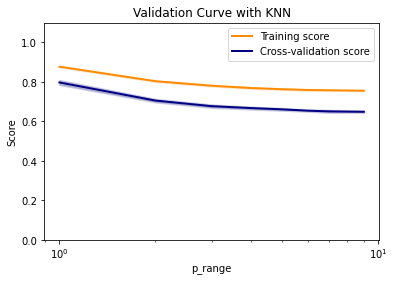

In [210]:
validation_curve_plot(p_range, knn_p_train_score_mean, knn_p_train_score_std, knn_p_test_score_mean, knn_p_test_score_std, "p_range", "Validation Curve with KNN")

###### On affine l'intervalle tel que:

In [211]:
p_range = np.arange(1, 4, 1)

##### On cherche maintenant les hyperparamètres idéaux

In [212]:
param_distributions = {'n_neighbors': n_neighbors_range,                       
                       'weights' : weights_range,
                       'algorithm': algorithm_range,
                       'p' : p_range}

search = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 310, in _check_algorithm_metric
    raise ValueError("unrecognized algorithm: '%s'" % self.algorithm)
ValueError: unrecognized algorithm: 'kid_tree'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\quent\anac

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=5,
                   param_distributions={'algorithm': ['ball_tree', 'kid_tree',
                                                      'brute'],
                                        'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
                                        'p': array([1, 2, 3]),
                                        'weights': ['uniform', 'distance']},
                   random_state=0)

In [213]:
search.best_params_, search.score(x_train, y_train)

({'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'algorithm': 'brute'},
 0.8143576222435283)

In [214]:
if (search.score(x_train, y_train) > accuracy_knn_model):
    knn_model = search

In [215]:
liste_modeles_train["KNN"] = knn_model

#### Random Forest

##### Test modèle sans hyper-paramètres

In [216]:
from sklearn.ensemble import RandomForestClassifier

In [217]:
rfc_model = RandomForestClassifier()

In [218]:
accuracy_rfc_model = test_model(rfc_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s finished


In [219]:
accuracy_rfc_model

0.9825022666109173

##### Test sur les hyper-paramètres : "n_estimators", "criterion", "max_depth", "min_samples_leaf", "max_features"

In [220]:
n_estimators_range = np.arange(100, 1100, 200)
criterion_range = ['gini', 'entropy']
max_depth_range = np.arange(1, 100, 5)
min_samples_leaf_range = np.arange(1, 10, 1)
max_features_range = ['auto', 'sqrt', 'log2']

###### On commence par affecter un large espace de recherche pour la valeur optimale de "n_estimators" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [221]:
rfc_n_estimators_train_score, rfc_n_estimators_test_score = validation_curve(rfc_model, x_train, y_train,
                       'n_estimators', n_estimators_range, verbose=1)

rfc_n_estimators_train_score_mean = np.mean(rfc_n_estimators_train_score, axis=1)
rfc_n_estimators_train_score_std = np.std(rfc_n_estimators_train_score, axis=1)

rfc_n_estimators_test_score_mean = np.mean(rfc_n_estimators_test_score, axis=1)
rfc_n_estimators_test_score_std = np.std(rfc_n_estimators_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=n_estimators, param_range=[100 300 500 700 900] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.2min finished


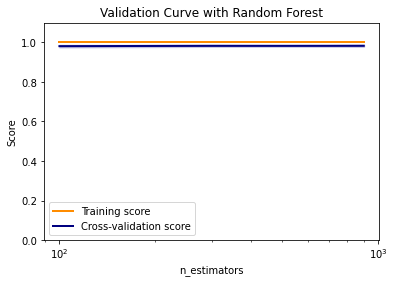

In [222]:
validation_curve_plot(n_estimators_range, rfc_n_estimators_train_score_mean, rfc_n_estimators_train_score_std, rfc_n_estimators_test_score_mean, rfc_n_estimators_test_score_std, "n_estimators", "Validation Curve with Random Forest")

###### On arrive à la conclusion que n_estimators n'est pas un hyperparamètre intéréssant à manipuler !

###### On commence par affecter un large espace de recherche pour la valeur optimale de "max_depth" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [223]:
rfc_max_depth_train_score, rfc_max_depth_test_score = validation_curve(rfc_model, x_train, y_train,
                       'max_depth', max_depth_range, verbose=1)

rfc_max_depth_train_score_mean = np.mean(rfc_max_depth_train_score, axis=1)
rfc_max_depth_train_score_std = np.std(rfc_max_depth_train_score, axis=1)

rfc_max_depth_test_score_mean = np.mean(rfc_max_depth_test_score, axis=1)
rfc_max_depth_test_score_std = np.std(rfc_max_depth_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=max_depth, param_range=[ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


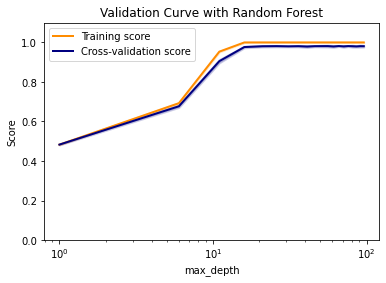

In [224]:
validation_curve_plot(max_depth_range, rfc_max_depth_train_score_mean, rfc_max_depth_train_score_std, rfc_max_depth_test_score_mean, rfc_max_depth_test_score_std, "max_depth", "Validation Curve with Random Forest")

###### On affine l'intervalle tel que:

In [225]:
max_depth_range = np.arange(25, 75, 5)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "min_samples_split" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [226]:
rfc_min_samples_leaf_train_score, rfc_min_samples_leaf_test_score = validation_curve(rfc_model, x_train, y_train,
                       'min_samples_leaf', min_samples_leaf_range, verbose=1)

rfc_min_samples_leaf_train_score_mean = np.mean(rfc_min_samples_leaf_train_score, axis=1)
rfc_min_samples_leaf_train_score_std = np.std(rfc_min_samples_leaf_train_score, axis=1)

rfc_min_samples_leaf_test_score_mean = np.mean(rfc_min_samples_leaf_test_score, axis=1)
rfc_min_samples_leaf_test_score_std = np.std(rfc_min_samples_leaf_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=min_samples_leaf, param_range=[1 2 3 4 5 6 7 8 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   42.5s finished


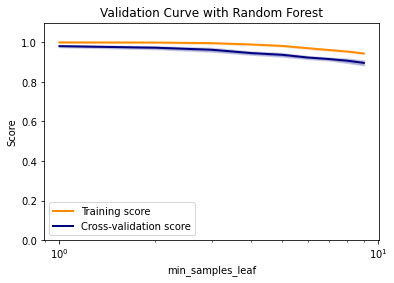

In [227]:
validation_curve_plot(min_samples_leaf_range, rfc_min_samples_leaf_train_score_mean, rfc_min_samples_leaf_train_score_std, rfc_min_samples_leaf_test_score_mean, rfc_min_samples_leaf_test_score_std, "min_samples_leaf", "Validation Curve with Random Forest")

###### On affine l'intervalle tel que:

In [228]:
n_estimators_range = np.arange(1, 3, 1)

##### On cherche maintenant les hyperparamètres idéaux

In [229]:
param_distributions = {'criterion': criterion_range,
                       'max_depth': max_depth_range,
                       'min_samples_split': min_samples_leaf_range,
                       'max_features': max_features_range}

search = RandomizedSearchCV(estimator=RandomForestClassifier(),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=0)

In [230]:
search.best_params_, search.score(x_train, y_train)

({'min_samples_split': 8,
  'max_features': 'auto',
  'max_depth': 25,
  'criterion': 'entropy'},
 0.9995206136145733)

In [231]:
if (search.score(x_train, y_train) > accuracy_rfc_model):
    rfc_model = search

In [232]:
liste_modeles_train["Random_Forest"] = rfc_model

#### Support Vector Machines

##### Test modèle sans hyper-paramètres

In [233]:
from sklearn.svm import SVC

In [234]:
svm_model = SVC()

In [235]:
accuracy_svm_model = test_model(svm_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished


In [236]:
accuracy_svm_model

0.6819270287784152

##### Test sur les hyper-paramètres : "C", "kernel"

In [237]:
C_range = np.logspace(1, 4, 6)
kernel_range = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

###### On commence par affecter un large espace de recherche pour la valeur optimale de "C" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [238]:
svm_C_train_score, svm_C_test_score = validation_curve(svm_model, x_train, y_train,
                       'C', C_range, verbose=1)

svm_C_train_score_mean = np.mean(svm_C_train_score, axis=1)
svm_C_train_score_std = np.std(svm_C_train_score, axis=1)

svm_C_test_score_mean = np.mean(svm_C_test_score, axis=1)
svm_C_test_score_std = np.std(svm_C_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=C, param_range=[   10.            39.81071706   158.48931925   630.95734448
  2511.88643151 10000.        ] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


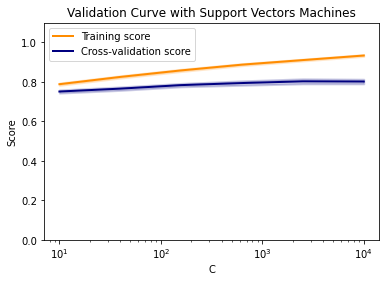

In [239]:
validation_curve_plot(C_range, svm_C_train_score_mean, svm_C_train_score_std, svm_C_test_score_mean, svm_C_test_score_std, "C", "Validation Curve with Support Vectors Machines")

###### On affine l'intervalle tq

In [240]:
C_range = np.logspace(3, 4, 6)

##### On cherche maintenant les hyperparamètres idéaux

In [241]:
param_distributions = {'C': C_range,
                       'kernel': kernel_range}

search = RandomizedSearchCV(estimator=SVC(),
                            n_iter=2,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

RandomizedSearchCV(estimator=SVC(), n_iter=2,
                   param_distributions={'C': array([ 1000.        ,  1584.89319246,  2511.88643151,  3981.07170553,
        6309.5734448 , 10000.        ]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid', 'precomputed']},
                   random_state=0)

In [242]:
search.best_params_, search.score(x_train, y_train)

({'kernel': 'rbf', 'C': 1000.0}, 0.8941754554170661)

In [243]:
if (search.score(x_train, y_train) > accuracy_svm_model):
    svm_model = search

In [244]:
liste_modeles_train["Support_Vector_Machines"] = svm_model

#### Naive Bayes

##### Test modèle sans hyper-paramètres

In [245]:
from sklearn.naive_bayes import GaussianNB

In [246]:
gnb_model = GaussianNB()

In [247]:
accuracy_gnb_model = test_model(gnb_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [248]:
accuracy_gnb_model

0.3080052674457199

##### Test sur les hyper-paramètres : "C", "kernel", "gamma"

In [249]:
var_smoothing_range = np.arange(1, 10, 1)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "var_smoothing" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [250]:
gnb_var_smoothing_train_score, gnb_var_smoothing_test_score = validation_curve(gnb_model, x_train, y_train,
                       'var_smoothing', var_smoothing_range, verbose=1)

gnb_var_smoothing_train_score_mean = np.mean(gnb_var_smoothing_train_score, axis=1)
gnb_var_smoothing_train_score_std = np.std(gnb_var_smoothing_train_score, axis=1)

gnb_var_smoothing_test_score_mean = np.mean(gnb_var_smoothing_test_score, axis=1)
gnb_var_smoothing_test_score_std = np.std(gnb_var_smoothing_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=var_smoothing, param_range=[1 2 3 4 5 6 7 8 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.8s finished


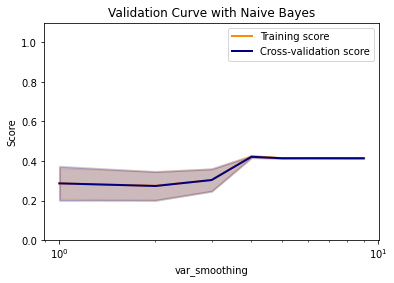

In [251]:
validation_curve_plot(var_smoothing_range, gnb_var_smoothing_train_score_mean, gnb_var_smoothing_train_score_std, gnb_var_smoothing_test_score_mean, gnb_var_smoothing_test_score_std, "var_smoothing", "Validation Curve with Naive Bayes")

###### On affine l'intervalle tq

In [252]:
var_smoothing_range = np.arange(5, 10, 1)

##### On cherche maintenant les hyperparamètres idéaux

In [253]:
param_distributions = {'var_smoothing': var_smoothing_range}

search = RandomizedSearchCV(estimator=GaussianNB(),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

RandomizedSearchCV(estimator=GaussianNB(), n_iter=5,
                   param_distributions={'var_smoothing': array([5, 6, 7, 8, 9])},
                   random_state=0)

In [254]:
search.best_params_, search.score(x_train, y_train)

({'var_smoothing': 6}, 0.4156279961649089)

In [255]:
if (search.score(x_train, y_train) > accuracy_gnb_model):
    gnb_model = search

In [256]:
liste_modeles_train["Naive_Bayes"] = gnb_model

# Test des modèles

### On va pouvoir tester notre modèle sur le dataset de test et décider quel modèle est le plus performant !

In [257]:
for model in liste_modeles_train.items():
    model[1].fit(x_test, y_test)
    liste_modeles_train[model[0]] = (model[1].score(x_test, y_test))

C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

In [258]:
liste_modeles_train= (sorted(liste_modeles_train.items(),
                           key=lambda item: item[1],
                           reverse=True))

In [259]:
liste_modeles_train

[('Random_Forest', 0.9995206136145733),
 ('Support_Vector_Machines', 0.9324065196548418),
 ('KNN', 0.7583892617449665),
 ('Linear_Regression', 0.5618408437200384),
 ('Naive_Bayes', 0.39789069990412274)]

In [260]:
print("On prend le modèle "+ str(liste_modeles_train[0][0]) + " d'une précision de : " + str(liste_modeles_train[0][1]))

On prend le modèle Random_Forest d'une précision de : 0.9995206136145733


In [261]:
filename = 'finalized_model.sav'
pickle.dump(rfc_model, open(filename, 'wb'))